In [33]:
# preamble
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run lib/preamble.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models

In [2]:
def zero_r():
    def train_fn(model, train, *args, **kwargs):
        """ train a model """
        model["zero_r"] = Counter(train["y"][:,0]).most_common(1)[0][0]

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        return [model["zero_r"]] * len(test["y"])

    def save_fn(outpath, model):
        """ save a trained model """
        with open(outpath, "wb") as outfile:
            pickle.dump(model, outfile)
    
    def load_fn(inpath):
        """ load a trained model """
        with open(inpath, "rb") as infile:
            model = pickle.load(infile)
        return model
        
    return {
        "name": "zero_r",
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [8]:
def cgo13():
    def create_model(seed=204, **kwargs):
        """ instantiate a model """ 
        return DecisionTreeClassifier(random_state=seed, splitter="best", criterion="entropy")

    def train_fn(model, train, validation, *args, **kwargs):
        """ train a model """
        np.random.seed(seed)
        model.fit(train["x_4"], train["y"])
        return {}

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        np.random.seed(seed)
        return model.predict(test["x_4"])
    
    def save_fn(outpath, model):
        """ save a trained model """
        with open(outpath, "wb") as outfile:
            pickle.dump(model, outfile)
    
    def load_fn(inpath):
        """ load a trained model """
        with open(inpath, "rb") as infile:
            model = pickle.load(infile)
        return model
        
    return {
        "name": "cgo13",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [4]:
def harry():
    BATCH_SIZE = 64
    EMBEDDING_VECTOR_LEN = 64
    
    def create_model(*args, data_desc=None, **kwargs):
        """ instantiate a model """ 
        atomizer = data_desc["atomizer"]
        seq_length = data_desc["seq_length"]
        vocab_size = atomizer.vocab_size + 1

        dyn_inputs = Input(shape=(2,), name="data_in")
        left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

        seq_inputs = Input(shape=(seq_length,), dtype="int32", name="code_in")
        right = Embedding(output_dim=EMBEDDING_VECTOR_LEN, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
        right = LSTM(16, consume_less="mem")(right)
        right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

        aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

        x = merge([left, right], mode="concat")
        x = Dense(18, activation="relu")(x)
        out = Dense(2, activation="sigmoid", name="out")(x)

        model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
        model.compile(optimizer="adam",
                      loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                      loss_weights={"out": 1., "aux_out": .2},
                      metrics=['accuracy'])
        return model
    
    def train_fn(model, train, *args, validation=None, **kwargs):
        """ train a model """
        model.fit({"data_in": train["x_2"], "code_in": train["x_seq"]},
                  {"out": train["y_2"], "aux_out": train["y_2"]},
                  nb_epoch=1,
                  batch_size=BATCH_SIZE,
                  validation_data=({"data_in": validation["x_2"], "code_in": validation["x_seq"]},
                                   {"out": validation["y_2"], "aux_out": validation["y_2"]}),
                  verbose=1,
                  shuffle=True)

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        predictions = np.array(model.predict({"data_in": test["x_2"], "code_in": test["x_seq"]},
                                             batch_size=BATCH_SIZE, verbose=0))
        clipped = [np.argmax(x) for x in predictions[0]]
        return clipped

    def save_fn(outpath, model):
        """ save a trained model """
        model.save(outpath)
    
    def load_fn(inpath):
        """ load a trained model """
        return load_model(inpath)

    return {
        "name": "harry",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

In [5]:
def sally():
    BATCH_SIZE = 64
    EMBEDDING_VECTOR_LEN = 64
    
    def create_model(*args, data_desc=None, **kwargs):
        """ instantiate a model """ 
        atomizer = data_desc["atomizer"]
        seq_length = data_desc["seq_length"]
        vocab_size = atomizer.vocab_size + 1

        dyn_inputs = Input(shape=(2,), name="data_in")
        left = BatchNormalization(name="dynprop_norm")(dyn_inputs)

        seq_inputs = Input(shape=(seq_length,), dtype="int32", name="code_in")
        right = Embedding(output_dim=EMBEDDING_VECTOR_LEN, input_dim=vocab_size, input_length=seq_length)(seq_inputs)
        right = LSTM(32, consume_less="mem", return_sequences=True)(right)
        right = LSTM(32, consume_less="mem")(right)
        right = BatchNormalization(input_shape=(32,), name="lstm_norm")(right)

        aux_out = Dense(2, activation="sigmoid", name="aux_out")(right)

        x = merge([left, right], mode="concat")
        x = Dense(34, activation="relu")(x)
        x = Dense(34, activation="relu")(x)
        out = Dense(2, activation="sigmoid", name="out")(x)

        model = Model(input=[dyn_inputs, seq_inputs], output=[out, aux_out])
        model.compile(optimizer="adam",
                      loss={"out": "categorical_crossentropy", "aux_out": "categorical_crossentropy"},
                      loss_weights={"out": 1., "aux_out": .2},
                      metrics=['accuracy'])
        return model
    
    def train_fn(model, train, *args, validation=None, **kwargs):
        """ train a model """
        model.fit({"data_in": train["x_2"], "code_in": train["x_seq"]},
                  {"out": train["y_2"], "aux_out": train["y_2"]},
                  nb_epoch=1,
                  batch_size=BATCH_SIZE,
                  validation_data=({"data_in": validation["x_2"], "code_in": validation["x_seq"]},
                                   {"out": validation["y_2"], "aux_out": validation["y_2"]}),
                  verbose=1,
                  shuffle=True)

    def test_fn(model, test, seed, *args, **kwargs):
        """ make predictions for test data """
        predictions = np.array(model.predict({"data_in": test["x_2"], "code_in": test["x_seq"]},
                                             batch_size=BATCH_SIZE, verbose=0))
        clipped = [np.argmax(x) for x in predictions[0]]
        return clipped

    def save_fn(outpath, model):
        """ save a trained model """
        model.save(outpath)
    
    def load_fn(inpath):
        """ load a trained model """
        return load_model(inpath)

    return {
        "name": "sally",
        "create_model": create_model,
        "train_fn": train_fn,
        "test_fn": test_fn,
        "save_fn": save_fn,
        "load_fn": load_fn
    }

# Evaluate

In [21]:
from itertools import product

seeds = list(range(204, 214))
source = "B"
split = (.6, .2, .2)

data_in = []

def source2str(s):
    if s == "B":
        return "Benchmarks"
    elif s == "S":
        return "CLgen"
    elif s == "BS":
        return "w. CLgen"
    else:
        raise Exception
        
def model2str(m):
    if m == "zero_r":
        return "Zero-R"
    elif m == "cgo13":
        return "Grewe et al."
    else:
        return m.title()

### Character Atomizer

In [34]:
# %%capture
for model, platform, seed in product(["zero_r", "cgo13", "harry", "sally"], ["amd", "nvidia"], seeds):
    m = globals().get(model)()
    model_path = get_model_path(m, platform, source, split=split, atomizer="CharacterAtomizer", seed=seed)
    if fs.exists(model_path):
        r = load_and_test(m, platform, source, split=split, atomizer=CharacterAtomizer, seed=seed)
        r["acc_perc"] = r["accuracy"] * 100
        r["model"] = model
        r["model_name"] = model.upper()
        r["platform"] = platform
        r["platform_name"] = platform.upper()
        r["oracle_perc"] = r["speedup_avg"] * 100
        r["source"] = source
        r["source_name"] = source2str(source)
        r["split"] = split
        data_in.append(r)
    else:
        print("warning: no model file", model_path, file=sys.stderr)

data = pd.DataFrame(data_in)

model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-204.model
[[79  0]
 [66  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-205.model
[[73  0]
 [55  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-206.model
[[77  0]
 [54  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-207.model
[[79  0]
 [50  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-208.model
[[86  0]
 [53  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-209.model
[[81  0]
 [64  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-210.model
[[77  0]
 [57  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-211.model
[[91  0]
 [56  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-212.model
[[93  0]
 [57  0]]
model loaded from models/zero_r/amd-B-60:20:20-CharacterAtomizer:1024-213.model
[[75  0]
 [53  0]]
model load

model loaded from models/sally/amd-B-60:20:20-CharacterAtomizer:1024-204.model
[[73  6]
 [27 39]]
model loaded from models/sally/amd-B-60:20:20-CharacterAtomizer:1024-205.model
[[61 12]
 [13 42]]
model loaded from models/sally/amd-B-60:20:20-CharacterAtomizer:1024-206.model
[[68  9]
 [14 40]]
model loaded from models/sally/amd-B-60:20:20-CharacterAtomizer:1024-207.model
[[71  8]
 [20 30]]
model loaded from models/sally/amd-B-60:20:20-CharacterAtomizer:1024-208.model
[[71 15]
 [12 41]]


In [35]:
data

,acc_perc,accuracy,confusion_matrix,model,model_name,oracle_perc,platform,platform_name,predictions,source,source_name,speedup_avg,speedup_geo,speedup_max,speedup_min,speedups,split
0,54.482759,0.544828,"[[79, 0], [66, 0]]",zero_r,ZERO_R,74.674029,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.746740,0.565441,1.0,0.006489,"[0.438757511608, 1.0, 0.451091432397, 1.0, 0.7...","(0.6, 0.2, 0.2)"
1,57.031250,0.570312,"[[73, 0], [55, 0]]",zero_r,ZERO_R,74.866854,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.748669,0.569144,1.0,0.014138,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","(0.6, 0.2, 0.2)"
2,58.778626,0.587786,"[[77, 0], [54, 0]]",zero_r,ZERO_R,78.378072,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.783781,0.636040,1.0,0.007296,"[1.0, 1.0, 1.0, 1.0, 0.440882331158, 1.0, 0.69...","(0.6, 0.2, 0.2)"
3,61.240310,0.612403,"[[79, 0], [50, 0]]",zero_r,ZERO_R,76.548120,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.765481,0.583827,1.0,0.006489,"[0.171586464762, 0.0655075026966, 1.0, 0.25843...","(0.6, 0.2, 0.2)"
4,61.870504,0.618705,"[[86, 0], [53, 0]]",zero_r,ZERO_R,76.175333,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.761753,0.586141,1.0,0.006489,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75107281...","(0.6, 0.2, 0.2)"
5,55.862069,0.558621,"[[81, 0], [64, 0]]",zero_r,ZERO_R,74.829913,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.748299,0.573269,1.0,0.006489,"[1.0, 1.0, 1.0, 0.195373591753, 1.0, 1.0, 1.0,...","(0.6, 0.2, 0.2)"
6,57.462687,0.574627,"[[77, 0], [57, 0]]",zero_r,ZERO_R,73.710968,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.737110,0.551494,1.0,0.028333,"[0.171586464762, 0.0655075026966, 0.4510914323...","(0.6, 0.2, 0.2)"
7,61.904762,0.619048,"[[91, 0], [56, 0]]",zero_r,ZERO_R,78.141058,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.781411,0.634793,1.0,0.028487,"[0.438757511608, 1.0, 0.451091432397, 1.0, 1.0...","(0.6, 0.2, 0.2)"
8,62.000000,0.620000,"[[93, 0], [57, 0]]",zero_r,ZERO_R,77.799374,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.777994,0.604189,1.0,0.014138,"[1.0, 1.0, 0.195373591753, 0.137392764843, 1.0...","(0.6, 0.2, 0.2)"
9,58.593750,0.585938,"[[75, 0], [53, 0]]",zero_r,ZERO_R,77.721776,amd,AMD,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",B,Benchmarks,0.777218,0.623137,1.0,0.028333,"[1.0, 0.451091432397, 1.0, 1.0, 1.0, 1.0, 0.88...","(0.6, 0.2, 0.2)"


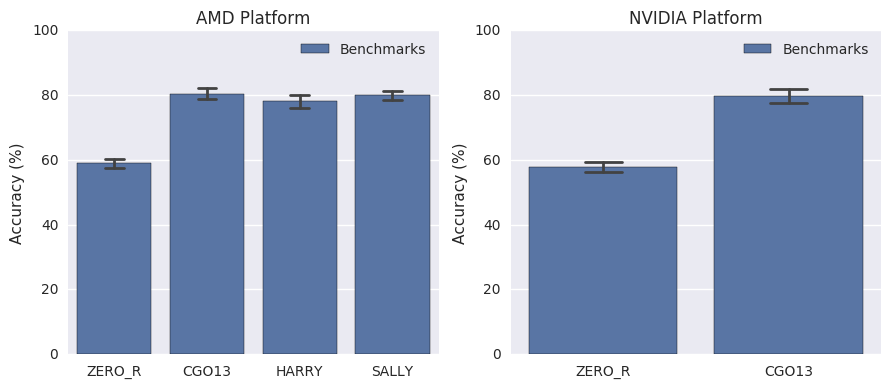

In [36]:
for i, platform in enumerate(["AMD", "NVIDIA"]):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(x="model_name", y="acc_perc", hue="source_name",
                    data=data[data["platform_name"] == platform],
                    ci=99, errwidth=2, capsize=.2)
    ax.get_legend().set_title("")  # no legend title
    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Accuracy (%)")
    plt.xlabel("")

viz.finalise(figsize=(9,4))

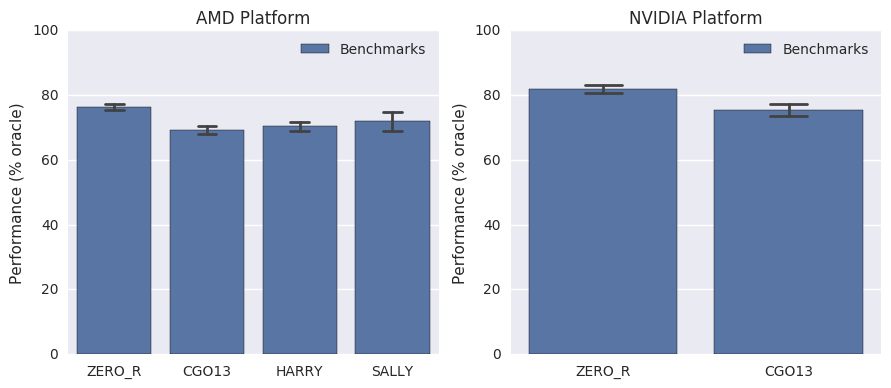

In [37]:
for i, platform in enumerate(["AMD", "NVIDIA"]):
    plt.subplot(1, 2, i + 1)
    ax = sns.barplot(x="model_name", y="oracle_perc", hue="source_name",
                     data=data[data["platform_name"] == platform],
                     ci=99, errwidth=2, capsize=.2)
    ax.get_legend().set_title("")  # no legend title
    plt.ylim((0, 100))
    plt.title("{platform} Platform".format(platform=platform.upper()))
    plt.ylabel("Performance (% oracle)")
    plt.xlabel("")

viz.finalise(figsize=(9,4))